In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Define Model

In [ ]:
class DoubleConv(nn.Module):
    """반복되는 conv - BN - ReLU 구조 모듈화"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Hyper Parameters

In [ ]:
lr= 0.001
epochs = 100
batch_size = 16


## Data Loader

In [ ]:
train_transform = A.Compose(
    [
        A.RandomCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)
test_transform = A.Compose(
    [
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/data/train', transform=train_transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

In [ ]:
dataset_size =  len(train_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.1 * dataset_size )
subset_indices = torch.randperm(dataset_size)[:subset_size]
subset_dataset = Subset(train_dataset, subset_indices)
subset_dataloader = DataLoader(subset_dataset, batch_size, shuffle=True, num_workers=2)

In [ ]:
test_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/data/test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

dataset_size =  len(test_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.2 * dataset_size)
subset_indices = torch.randperm(dataset_size)[:subset_size]
mini_test = Subset(test_dataset, subset_indices)
mini_test_loader = DataLoader(mini_test, batch_size, shuffle=True, num_workers=2)

## Model Train

In [ ]:
# model 초기화
model = UNet(3,1).to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(mini_test_loader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(mini_test_loader))


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(mini_test_loader)}')



100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


Epoch 1, Loss: 0.4660103142261505, Test Loss : 0.8990565873682499


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 2, Loss: 0.36171330213546754, Test Loss : 0.5397125296294689


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 3, Loss: 0.33048651019732156, Test Loss : 0.5372604578733444


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 4, Loss: 0.2965575565894445, Test Loss : 0.865572139620781


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Epoch 5, Loss: 0.2878689448038737, Test Loss : 0.3370667155832052


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 6, Loss: 0.26780642867088317, Test Loss : 0.2782095056027174


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 7, Loss: 0.27058828274408975, Test Loss : 0.29404829628765583


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch 8, Loss: 0.27545213599999746, Test Loss : 0.3019384741783142


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 9, Loss: 0.24487069149812063, Test Loss : 0.3373455423861742


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 10, Loss: 0.22920644382635752, Test Loss : 0.2867615092545748


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch 11, Loss: 0.23493698040644329, Test Loss : 0.27175389416515827


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 12, Loss: 0.24616748690605164, Test Loss : 0.3679239749908447


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 13, Loss: 0.23058701157569886, Test Loss : 0.30591701343655586


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 14, Loss: 0.23204522629578908, Test Loss : 0.26827225647866726


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 15, Loss: 0.23352632721265157, Test Loss : 0.27583898417651653


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 16, Loss: 0.23776919047037762, Test Loss : 0.2739441189914942


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 17, Loss: 0.23438431620597838, Test Loss : 0.2710389383137226


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 18, Loss: 0.22582539717356365, Test Loss : 0.27691703103482723


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 19, Loss: 0.21514915227890014, Test Loss : 0.27538657560944557


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 20, Loss: 0.21767228444417316, Test Loss : 0.27433507330715656


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 21, Loss: 0.2035698999961217, Test Loss : 0.2620188966393471


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 22, Loss: 0.2066522757212321, Test Loss : 0.278631504625082


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 23, Loss: 0.2030699670314789, Test Loss : 0.2660039812326431


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 24, Loss: 0.23836183349291484, Test Loss : 0.24345511198043823


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 25, Loss: 0.22692747314771017, Test Loss : 0.24911439092829823


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 26, Loss: 0.2169319768746694, Test Loss : 0.2867621537297964


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Epoch 27, Loss: 0.19737913558880488, Test Loss : 0.2496226280927658


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch 28, Loss: 0.20590903560320536, Test Loss : 0.2614073846489191


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 29, Loss: 0.19352173308531442, Test Loss : 0.23126249201595783


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 30, Loss: 0.2020606388648351, Test Loss : 0.2372531984001398


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 31, Loss: 0.20231995383898418, Test Loss : 0.28819434717297554


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch 32, Loss: 0.20600134432315825, Test Loss : 0.22520610317587852


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 33, Loss: 0.21067173779010773, Test Loss : 0.2376954648643732


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 34, Loss: 0.20777776340643564, Test Loss : 0.23792382515966892


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 35, Loss: 0.20191568235556284, Test Loss : 0.24071822687983513


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Epoch 36, Loss: 0.20314893821875254, Test Loss : 0.4071671776473522


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 37, Loss: 0.20994006991386413, Test Loss : 0.21899987384676933


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 38, Loss: 0.18757908443609875, Test Loss : 0.24302981793880463


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 39, Loss: 0.19674815038839977, Test Loss : 0.2842720299959183


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Epoch 40, Loss: 0.19475605934858323, Test Loss : 0.24739421159029007


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Epoch 41, Loss: 0.18267012933890026, Test Loss : 0.3231352027505636


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 42, Loss: 0.18019243280092875, Test Loss : 0.2677755504846573


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Epoch 43, Loss: 0.17913006295760472, Test Loss : 0.23061097599565983


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 44, Loss: 0.18973553876082103, Test Loss : 0.22640131786465645


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 45, Loss: 0.19351153125365575, Test Loss : 0.2435889132320881


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 46, Loss: 0.18885040283203125, Test Loss : 0.22815448231995106


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 47, Loss: 0.18549152314662934, Test Loss : 0.20723467413336039


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 48, Loss: 0.19291584193706512, Test Loss : 0.21951613202691078


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Epoch 49, Loss: 0.19121163388093312, Test Loss : 0.22745354659855366


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 50, Loss: 0.18226413329442342, Test Loss : 0.23020756617188454


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 51, Loss: 0.19993557979663212, Test Loss : 0.2057826342061162


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 52, Loss: 0.17704414228598278, Test Loss : 0.22407866641879082


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 53, Loss: 0.17399672617514927, Test Loss : 0.24392257444560528


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 54, Loss: 0.1749451071023941, Test Loss : 0.23831592872738838


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 55, Loss: 0.1718709776798884, Test Loss : 0.22312275879085064


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 56, Loss: 0.18263143301010132, Test Loss : 0.22594578750431538


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 57, Loss: 0.17238815277814865, Test Loss : 0.2204708196222782


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Epoch 58, Loss: 0.1945040225982666, Test Loss : 0.2502217125147581


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch 59, Loss: 0.18873526006937028, Test Loss : 0.2312516923993826


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 60, Loss: 0.17521981249252955, Test Loss : 0.2282968033105135


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Epoch 61, Loss: 0.1863387847940127, Test Loss : 0.23311164416372776


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 62, Loss: 0.17784063816070556, Test Loss : 0.2300200778990984


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch 63, Loss: 0.19250768125057222, Test Loss : 0.23182306252419949


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 64, Loss: 0.1806023582816124, Test Loss : 0.42947230860590935


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 65, Loss: 0.1995868017276128, Test Loss : 0.22734558582305908


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 66, Loss: 0.17730197409788767, Test Loss : 0.21601511165499687


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch 67, Loss: 0.1854060689608256, Test Loss : 0.23745295777916908


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 68, Loss: 0.16338306317726772, Test Loss : 0.2497749999165535


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 69, Loss: 0.16816869974136353, Test Loss : 0.20826585963368416


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Epoch 70, Loss: 0.1684170072277387, Test Loss : 0.2412058264017105


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 71, Loss: 0.17714961965878803, Test Loss : 0.20774664729833603


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 72, Loss: 0.17260371694962184, Test Loss : 0.22497851587831974


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Epoch 73, Loss: 0.1795554965734482, Test Loss : 0.21195385791361332


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 74, Loss: 0.17250962058703104, Test Loss : 0.24741828255355358


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 75, Loss: 0.1894570678472519, Test Loss : 0.25559257715940475


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Epoch 76, Loss: 0.17921802401542664, Test Loss : 0.21032426413148642


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Epoch 77, Loss: 0.15927709291378658, Test Loss : 0.24329074285924435


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 78, Loss: 0.1757438083489736, Test Loss : 0.20797985419631004


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Epoch 79, Loss: 0.172476194302241, Test Loss : 0.19972336664795876


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 80, Loss: 0.16968823224306107, Test Loss : 0.2082640305161476


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 81, Loss: 0.16932451923688252, Test Loss : 0.20009360648691654


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Epoch 82, Loss: 0.15698461482922235, Test Loss : 0.20498951338231564


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 83, Loss: 0.15806887497504551, Test Loss : 0.19307225104421377


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 84, Loss: 0.15316266069809595, Test Loss : 0.21875805221498013


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 85, Loss: 0.16201545894145966, Test Loss : 0.20182806067168713


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 86, Loss: 0.16770945837100346, Test Loss : 0.2170438338071108


100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 87, Loss: 0.18072874744733175, Test Loss : 0.2143490333110094


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch 88, Loss: 0.15429511070251464, Test Loss : 0.2254288997501135


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 89, Loss: 0.16058733264605204, Test Loss : 0.2413305714726448


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 90, Loss: 0.1613717257976532, Test Loss : 0.19895898085087538


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch 91, Loss: 0.14523826738198597, Test Loss : 0.1859206489752978


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 92, Loss: 0.14607428411642712, Test Loss : 0.20576723106205463


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 93, Loss: 0.14866890261570612, Test Loss : 0.1882963078096509


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Epoch 94, Loss: 0.167079725364844, Test Loss : 0.19270896539092064


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 95, Loss: 0.15630857745806376, Test Loss : 0.20311233028769493


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 96, Loss: 0.1584298441807429, Test Loss : 0.19161495752632618


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 97, Loss: 0.16233975042899448, Test Loss : 0.19872664287686348


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 98, Loss: 0.15679778754711152, Test Loss : 0.18568504741415381


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Epoch 99, Loss: 0.15820878992478052, Test Loss : 0.21013603080064058


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

Epoch 100, Loss: 0.16633774141470592, Test Loss : 0.21751205995678902


In [ ]:
torch.save(model.state_dict(), './model.pt')

## Epoch에 따른 Loss 변화

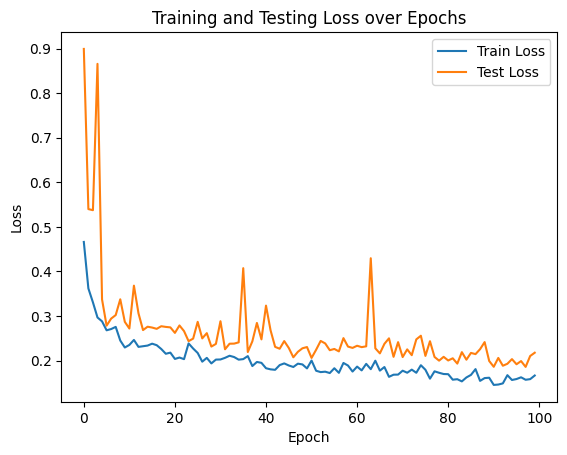

In [ ]:

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

In [ ]:
# with torch.no_grad():
#     model.eval()
#     img = train_dataset[0][0].unsqueeze(0).float().to(device)

#     output = model(img)
#     output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() #output에 sigmoid => 건물일 확률 + shape 이미지 RGB 모양으로
#     output = (output > 0.5).astype(np.uint8) # Threshold = 0.5 이상이면 건물이라 판단
#     output = output*255 # 1이면 하얗게 출력하기 위해 255 곱하기

#     cv2_imshow(output)


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# 모델 인스턴스 생성 및 가중치 로드
model_trained = UNet(3,1).to(device)
model_trained.load_state_dict(torch.load('./model.pt')) # 'model_weights.pth'는 가중치 파일의 경로
model_trained.eval() # 평가 모드로 설정

# 이미지 전처리
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Normalize(),
        transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환
        # 추가적인 전처리 (예: 정규화, 크기 조정 등)가 필요한 경우 여기에 추가
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # 배치 차원 추가
    return input_batch

# 이미지 경로
image_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/images/austin1_0_0.jpg' # 'path_to_your_image.jpg'를 이미지 파일 경로로 대체

# 이미지 전처리 및 예측 수행
with torch.no_grad():
    input_batch = preprocess_image(image_path)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_trained.to('cuda')

    output = model_trained(input_batch)

# 결과 처리
# 예: 세그멘테이션 결과를 이미지로 변환
output = output.squeeze().cpu().numpy() # 배치 차원 제거 및 넘파이 배열로 변환
# output = (output > 0.5).astype(np.uint8)
output_image = (output * 255).astype(np.uint8) # 이미지로 변환

# 결과 이미지 보기 (Matplotlib 사용)
plt.imshow(output_image, cmap='gray') # 'gray'는 흑백 이미지인 경우 사용
plt.axis('off') # 축 제거
plt.show()


TypeError: ignored

## 잘 되는지 결과 이미지 출력해보기

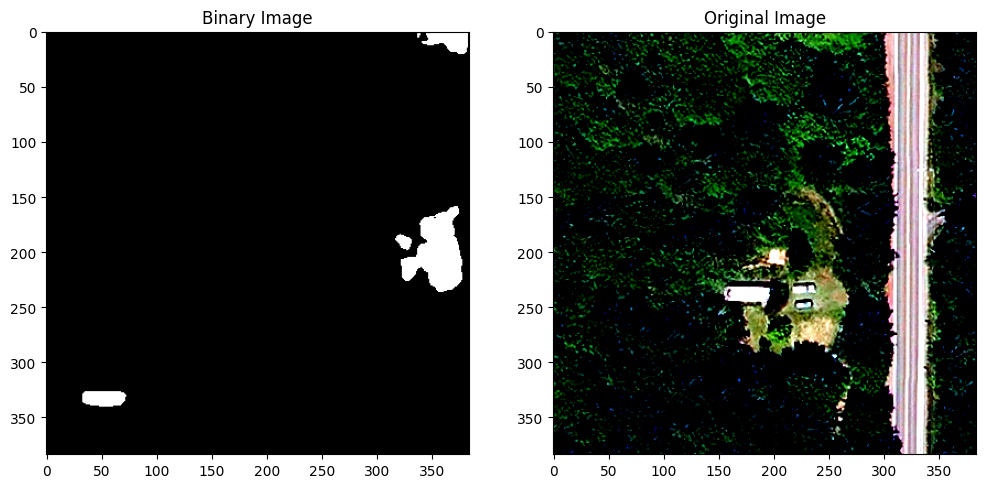

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    img = train_dataset[0][0].unsqueeze(0).float().to(device)
    original_img = train_dataset[0][0].numpy() # 원본 이미지

    output = model(img)
    output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() # Sigmoid 적용 및 이미지 형태로 변환
    output = (output > 0.5).astype(np.uint8) # Threshold 적용

    plt.figure(figsize=(12, 6))

    # 이진화된 이미지 (흑백)
    plt.subplot(1, 2, 1)
    plt.imshow(output, cmap='gray')
    plt.title('Binary Image')

    # 원본 이미지
    plt.subplot(1, 2, 2)
    plt.imshow(original_img.transpose(1, 2, 0)) # 이미지 배열을 적절히 변환
    plt.title('Original Image')

    plt.show()


## Grad Cam

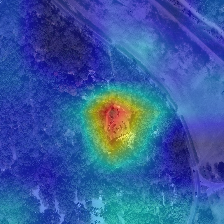

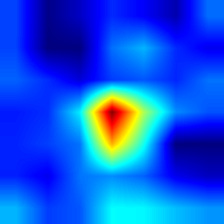

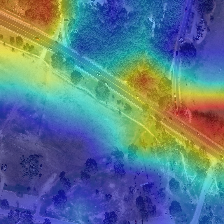

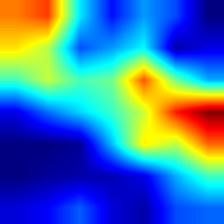

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torchvision.models import vgg16

model = vgg16(pretrained=True)

class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.forward_result = None
        self.backward_result = None
        self.register_hooks()

    def register_hooks(self):
        for module_name, module in self.model.named_modules():
            if module_name == self.module:
                for layer_name, submodule in module.named_children():
                    if layer_name == self.layer:
                        submodule.register_forward_hook(self.forward_hook)
                        submodule.register_backward_hook(self.backward_hook)

    def forward(self, input, target_index):
        outs = self.model(input)
        outs = outs.squeeze()

        if target_index is None:
            target_index = outs.argmax()

        outs[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()
        out = torch.relu(out) / torch.max(out)
        out = F.interpolate(out.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])


if __name__ == '__main__':
    def preprocess_image(img):
        means = [0.485, 0.456, 0.406]
        stds = [0.229, 0.224, 0.225]

        preprocessed_img = img.copy()[:, :, ::-1]
        for i in range(3):
            preprocessed_img[:, :, i] = (preprocessed_img[:, :, i] - means[i]) / stds[i]
        preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
        preprocessed_img = torch.from_numpy(preprocessed_img).float()
        preprocessed_img.unsqueeze_(0)
        input = preprocessed_img.requires_grad_(True)
        return input

    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        cv2_imshow(np.uint8(255 * cam))
        cv2_imshow(np.uint8(heatmap * 255))


    import os
    import cv2
    import glob

    model.eval()

    grad_cam = GradCam(model=model, module='features', layer='30')
    root = './data/test/images/'
    img_list = os.listdir(root)
    img_list = sorted(glob.glob(os.path.join(root, '*.jpg')))
    for img_path in img_list[:2]:
        img = cv2.imread(img_path, 1)
        img = np.float32(cv2.resize(img, (224, 224))) / 255
        input = preprocess_image(img)
        mask = grad_cam(input, None)
        show_cam_on_image(img, mask)

## Inference 및 최종 성능 평가

In [ ]:
all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(mini_test_loader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
precision = precision_score(true_masks_flat, predicted_masks_flat)
recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Precision: 0.8605383776454637
Recall: 0.6174344326028919
IoU: 0.5612716730014609
Dice Coefficient: 0.7189929628614169
